### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
from IPython.display import Image
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()

In [2]:
import analysis as an

## ISSUES


## Run Cyclus Input file

In [3]:
! rm month.sqlite
! cyclus input.xml -o month.sqlite --warn-limit 0 

              :                                                               
          .CL:CC CC             _Q     _Q  _Q_Q    _Q    _Q              _Q   
        CC;CCCCCCCC:C;         /_\)   /_\)/_/\\)  /_\)  /_\)            /_\)  
        CCCCCCCCCCCCCl       __O|/O___O|/O_OO|/O__O|/O__O|/O____________O|/O__
     CCCCCCf     iCCCLCC     /////////////////////////////////////////////////
     iCCCt  ;;;;;.  CCCC                                                      
    CCCC  ;;;;;;;;;. CClL.                          c                         
   CCCC ,;;       ;;: CCCC  ;                   : CCCCi                       
    CCC ;;         ;;  CC   ;;:                CCC`   `C;                     
  lCCC ;;              CCCC  ;;;:             :CC .;;. C;   ;    :   ;  :;;   
  CCCC ;.              CCCC    ;;;,           CC ;    ; Ci  ;    :   ;  :  ;  
   iCC :;               CC       ;;;,        ;C ;       CC  ;    :   ; .      
  CCCi ;;               CCC        ;;;.      .C ;   

In [4]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('month.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [5]:
# plotting function
import matplotlib.pyplot as plt
def stacked_bar(dictionary, timestep, xlabel, ylabel,
                title, outputname, init_year, width):
    prev =np.zeros(1)
    top_index = True
    plot_list = []
    for key in dictionary:
        label = str(key)
        if sum(dictionary[key]) == 0:
            print(label + ' has no values')
        elif top_index is True:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           label=label)
            prev = dictionary[key]
            top_index = False
            plot_list.append(plot)
        else:
            plot = plt.bar(x=init_year + timestep,
                           height=dictionary[key],
                           width=width,
                           edgecolor='none',
                           bottom=prev,
                           label=label)
            prev =np.add(prev, dictionary[key])
            plot_list.append(plot)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    axes = plt.gca()
    axes.autoscale(tight=True)
    plt.grid(True)
    plt.legend()
    plt.savefig(outputname + '.png', format='png',
                bbox_inches='tight')
    plt.close()
    

def twosum(timeseries_list):
    """Aggregates timeseries list of length 2x to x
       by summing up the two adjacent values"""
    result = [0]
    list_indx = 0
    total = 0
    while True:
        total += timeseries_list[list_indx]
        list_indx += 1
        if list_indx == len(timeseries_list) - 1:
            break
        if list_indx%12 == 0:
            result.append(total)
            total = 0
    return result

half_length = int((len(timestep)+1) / 12)
new_timestep = timestep[:half_length]


def read_from_data(data_path):
    """Reads from excel answer from Bo Feng from file"""
    file = open(data_path, 'r')
    timeseries = [0]
    for row in file:
        value = float(row.replace('\n', ''))
        timeseries.append(value)
    return timeseries[:-3]

### The output file should be named 
         
          month.sqlite

In [6]:
# get number of reactors and capacity timeseries
power_dict = an.get_power_dict(cur)
stacked_bar(power_dict, timestep, 'Year', 'Deployed Capacity [GWe]',
            'Deployed reactor capacityies at the end of each year.',
            'power_plot', init_year, 1)
! mv power_plot.png ./results/power_plot.png

fac has no values


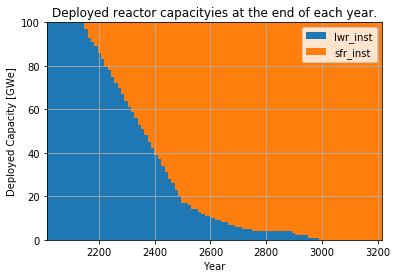

In [7]:
Image('./results/power_plot.png')

In [8]:
# get deployment scheme
dep_dict = {}

# lwr decommission
lwr_dec = cur.execute('SELECT exittime FROM agentexit '
                      'INNER JOIN agententry ON '
                      'agentexit.agentid = agententry.agentid '
                      'WHERE prototype = "lwr"').fetchall()
dec_array = np.zeros(duration)
exittime_list = []
for row in lwr_dec:
    exittime_list.append(row['exittime'])
for i in range(1,duration):
    dec_array[i-1] = exittime_list.count(i)

dep_dict['LWRs retired'] = dec_array

# sfr deployment
sfr_dep = cur.execute('SELECT entertime FROM agententry '
                      'where prototype = "sfr"').fetchall()
dep_array = np.zeros(duration)
entertime_list = []
for row in sfr_dep:
    entertime_list.append(row['entertime'])
for i in range(1, duration):
    dep_array[i-1] = entertime_list.count(i)

dep_dict['SFRs started up'] = dep_array


# read from data
data_lwr_decom = read_from_data('./bo/lwr_decom')
data_sfr_dep = read_from_data('./bo/sfr_deploy')


plt.bar(init_year + new_timestep, twosum(dep_dict['LWRs retired']),
        label='LWRs retired', width=0.8)
plt.plot(init_year + new_timestep, data_lwr_decom, label='LWRs retired [EXCEL]')

plt.bar(init_year + new_timestep, twosum(dep_dict['SFRs started up']),
        label='SFRs started up', alpha=0.4, width=0.8)
plt.plot(init_year + new_timestep, data_sfr_dep, label='SFRs started up [EXCEL]')

plt.ylabel('Reactors')
plt.xlabel('Year')
plt.title('LWRs retired and SFRs started up each year')
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.legend()
plt.yticks(np.arange(0,15, 2))
plt.savefig('./results/dep.png', format='png',
            bbox_inches='tight')
plt.close()


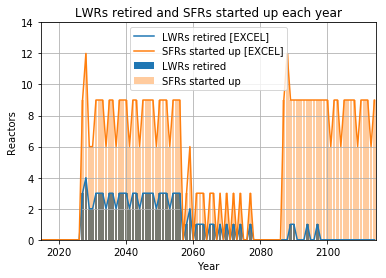

In [9]:
Image("./results/dep.png")

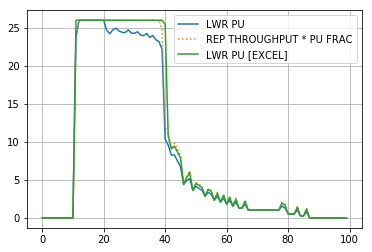

In [47]:
# sep lwr production


lwr_sep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
lwr_pu_prod = an.facility_commodity_flux(cur, lwr_sep_agentid, ['uox_pu'], True, False)

pu_output = cur.execute('SELECT time, value FROM separationevents '
                           'WHERE Type = "uox_pu" AND Agentid = ' + lwr_sep_agentid[0]).fetchall()
reprocessing_throughput = cur.execute('SELECT time, value FROM separationevents '
                                      'WHERE Type = "UNF" AND Agentid = ' + lwr_sep_agentid[0]).fetchall()

# sending uox_pu

uox_pu = np.array(twosum(an.get_timeseries(pu_output, duration, True)))
reprocessing_throughput = np.array(twosum(an.get_timeseries(reprocessing_throughput, duration, True))) * 0.013
data_lwr_pu = read_from_data('./bo/lwr_sep_tru')

plt.plot(new_timestep, uox_pu, label='LWR PU')
plt.plot(new_timestep, reprocessing_throughput, linestyle=':', label="REP THROUGHPUT * PU FRAC")
plt.plot(new_timestep, data_lwr_pu, label = 'LWR PU [EXCEL]')
plt.grid()
plt.legend()
plt.show()

## This result is because the CYCAMORE::REACTOR, when decommissioned mid-cycle, only depletes half of its core. The remaining half is un-depleted (enriched UOX). Thus half of the discharged fuel from decommissioned reactors do not contain plutonium.

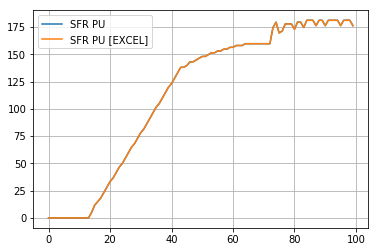

In [31]:
# sep sfr production
sfr_sep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_pu_prod = an.facility_commodity_flux(cur, sfr_sep_agentid, ['sfr_pu'], True, False)

sfr_pu = np.array(twosum(sfr_pu_prod['sfr_pu']))
data_sfr_pu = read_from_data('./bo/sfr_sep_tru')

plt.plot(new_timestep, sfr_pu, label='SFR PU')
plt.plot(new_timestep, data_sfr_pu, label='SFR PU [EXCEL]')
plt.grid()
plt.legend()
plt.show()

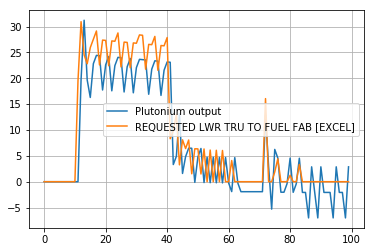

In [53]:
# requested LWR TRU to fuel fab
mixer_agentid = an.get_prototype_id(cur, 'sfr_mixer_sfr')
requested_lwr_tru = an.facility_commodity_flux(cur, mixer_agentid, ['uox_pu'], False, False)
requested_lwr_tru = np.array(twosum(requested_lwr_tru['uox_pu']))
data_lwr_tru = read_from_data('./bo/requested_lwr_tru')
tru_request = an.facility_commodity_flux(cur, mixer_agentid, ['sfr_fuel'], True, False)
tru_request = np.array(tru_request['sfr_fuel']) * 0.1387
tru_request = twosum(tru_request)

requested_lwr_tru = np.array(tru_request) - sfr_pu

#plt.plot(new_timestep, tru_request, label='tru request')
plt.plot(new_timestep, requested_lwr_tru , label = 'Plutonium output')
plt.plot(new_timestep, data_lwr_tru , label = 'REQUESTED LWR TRU TO FUEL FAB [EXCEL]')

plt.grid()
plt.legend()
plt.show()
plt.close()


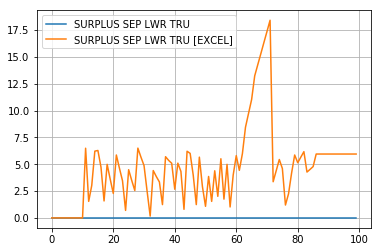

In [33]:
# surplus separated LWR TRU
surplus_lwr_tru = np.zeros(len(new_timestep))
for indx, val in enumerate(surplus_lwr_tru):
    if indx == 0:
        continue
    surplus_val = surplus_lwr_tru[indx-1] + uox_pu[indx] - requested_lwr_tru[indx]

data_surplus_lwr_tru = read_from_data('./bo/surplus_sep_lwr_tru')

plt.plot(new_timestep, surplus_lwr_tru, label='SURPLUS SEP LWR TRU')
plt.plot(new_timestep, data_surplus_lwr_tru, label='SURPLUS SEP LWR TRU [EXCEL]')

plt.grid()
plt.legend()
plt.show()
plt.close()
    

In [35]:
# unsed TRU recovered from UNF

# separated pu timeseries
pu_influx = cur.execute('SELECT time, Value FROM separationevents '
                        'WHERE type = "uox_pu" OR type = "sfr_pu"').fetchall()
pu_inv_timeseries = an.get_timeseries(pu_influx, duration, True)

# pu usage
sfr_agentid = an.get_prototype_id(cur, 'sfr_mixer_sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid, ['sfr_fuel'], True, False)
pu_used = np.array(sfr_load['sfr_fuel']) * 0.1387

# influx - outflux
leftover = [0]
for indx, value in enumerate(pu_inv_timeseries[1:]):
    remaining = leftover[indx-1] + value - pu_used[indx]
    leftover.append(remaining)


pu_leftover = np.array(twosum(leftover)) / 12
plt.plot(new_timestep, pu_leftover, label='TRU LEFTOVER')
plt.xlabel('Year')
plt.ylabel('Unused TRU from UNF [tHM]')
plt.title('Inventory of unused TRU recovered from UNF')
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/tru.png', format='png',
            bbox_inches='tight')
plt.close()

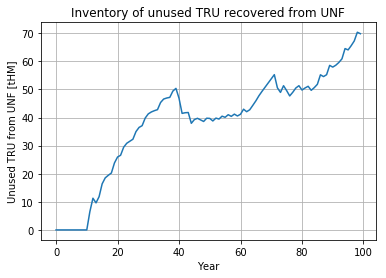

In [36]:
Image('./results/tru.png')

In [37]:
# Annual Fresh Fuel Loading Rates

# lwr fuel loading 
lwr_agentid = an.get_prototype_id(cur, 'lwr')
lwr_load = an.facility_commodity_flux(cur, lwr_agentid,
                                      ['uox'], False, False)
## have to make the first datapoint equal to the second datapoint (BC)
## the first datapoint lwr_load['uox'][1] 
## is the initial loading of all lwrs
lwr_load['uox'][1] = lwr_load['uox'][2]
lwr_load['uox'][0] = lwr_load['uox'][1]

# aggregate
new_lwr_load =  twosum(lwr_load['uox'])

# sfr fuel loading
sfr_agentid = an.get_prototype_id(cur, 'sfr')
sfr_load = an.facility_commodity_flux(cur, sfr_agentid,
                                      ['sfr_fuel'],
                                      False, False)
# aggregate
new_sfr_load = twosum(sfr_load['sfr_fuel'])

## Get from data
data_lwr_load = read_from_data('./bo/lwr_fuel_loaded')
data_sfr_load = read_from_data('./bo/sfr_fuel_loaded')


plt.plot(new_timestep + init_year , new_lwr_load,
         label='LWR Fresh Fuel')
plt.plot(new_timestep + init_year , data_lwr_load,
         label='LWR Fresh Fuel [EXCEL]', linestyle = ':')

plt.plot(new_timestep + init_year, new_sfr_load,
         label='SFR Fresh Fuel')
plt.plot(new_timestep + init_year, data_sfr_load,
         label='SFR Fresh Fuel [EXCEL]', linestyle = ':')

plt.xlabel('Year')
plt.ylabel('Fresh Fuel Loading [MTHM]')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/fuel_load.png', format='png',
            bbox_inches='tight')
plt.close()

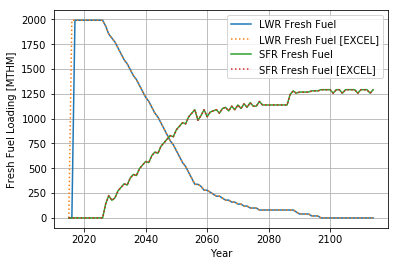

In [38]:
Image("./results/fuel_load.png")

In [39]:
# Inventory of discharged and cooled UNF waiting for reprocessing

query_result = cur.execute('SELECT quantity FROM storageinventory '
                           'WHERE prototype = "uox_unf_storage" '
                           'AND status = "Cooling"').fetchall()
uox_storage_timeseries = []
for row in query_result:
    uox_storage_timeseries.append(row[0] / 1000.0)

sfr_query = cur.execute('SELECT quantity FROM storageinventory '
                        'WHERE prototype = "sfr_unf_storage" '
                        'AND status = "Cooling"').fetchall()
sfr_storage_timeseries = []
for row in sfr_query:
    sfr_storage_timeseries.append(row[0] / 1000.0)

# average of two timesteps
new_uox_storage = np.array(twosum(uox_storage_timeseries)) / 12
new_sfr_storage = np.array(twosum(sfr_storage_timeseries)) / 12

## get from data
data_uox_storage = read_from_data('./bo/lwr_cool')
data_sfr_storage = read_from_data('./bo/sfr_cool')

plt.plot(new_timestep + init_year , new_uox_storage,
             label='LWR UNF')
plt.plot(new_timestep + init_year , data_uox_storage,
             label='LWR UNF [EXCEL]')

plt.plot(new_timestep + init_year, new_sfr_storage,
         label='SFR UNF')
plt.plot(new_timestep + init_year, data_sfr_storage,
         label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('Used Fuel in Cooling Storage [t]')
plt.title('Inventory of discharged UNF in mandatory cooling storage')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/fuel_discharge.png', format='png',
            bbox_inches='tight')
plt.close()

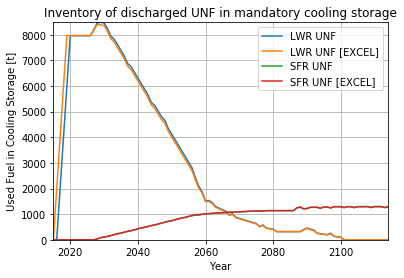

In [40]:
Image('./results/fuel_discharge.png')

In [41]:
# Inventory of discharged and cooled UNF waiting for reprocessing
# Inventory of discharged and cooled UNF waiting for reprocessing


uox_storage_agentid = an.get_prototype_id(cur, 'uox_unf_storage')
uox_sent_out = an.facility_commodity_flux(cur, uox_storage_agentid,
                                          ['cooled_uox_unf'],
                                          True, True)
cooled = cur.execute('SELECT time, quantity FROM storageinventory '
                     'WHERE prototype = "uox_unf_storage" '
                     'AND status = "Cooled Inventory"').fetchall()
cooled = an.get_timeseries(cooled, duration, True)

sfr_storage_agentid = an.get_prototype_id(cur, 'sfr_unf_storage')
sfr_sent_out = an.facility_commodity_flux(cur, sfr_storage_agentid,
                                          ['cooled_sfr_unf'],
                                          True, True)

# subtract unf used
# pu outflux from reprocessing plants
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_pu_out = an.facility_commodity_flux(cur, uox_rep_agentid,
                                        ['uox_pu'], True, True)
sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_pu_out = an.facility_commodity_flux(cur, sfr_rep_agentid,
                                        ['sfr_pu'], True, True)


# just reprocessed amount
agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT time, Value FROM separationevents '
                      'WHERE type = "UNF" '
                      'AND Agentid = ' + agentid[0]).fetchall()


uox_rep_cum = an.get_timeseries_cum(uox_rep, duration, True)


diff = - np.array(uox_rep_cum) + np.array(uox_sent_out['cooled_uox_unf']) + np.array(cooled)

sfr_diff = - np.array(sfr_pu_out['sfr_pu']) / 0.1404 + np.array(sfr_sent_out['cooled_sfr_unf'])


## Get from data
data_cooled_uox = read_from_data('./bo/lwr_cooled')
data_cooled_sfr = read_from_data('./bo/sfr_cooled')

# plot the average 
plt.plot(new_timestep + init_year, np.array(twosum(diff)) / 12, label='LWR UNF')
plt.plot(new_timestep + init_year, data_cooled_uox, label='LWR UNF [EXCEL]')


plt.plot(new_timestep + init_year, np.array(twosum(sfr_diff)) / 12, label='SFR UNF')
plt.plot(new_timestep + init_year, data_cooled_sfr, label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('UNF waiting for Reprocessing [MTHM]')
plt.title('Inventory of discharge and cooled UNF waiting for reprocessing')
plt.legend()
axes = plt.gca()
axes.autoscale(tight=True)
plt.grid(True)
plt.savefig('./results/waiting.png', format='png',
            bbox_inches='tight')
plt.close()

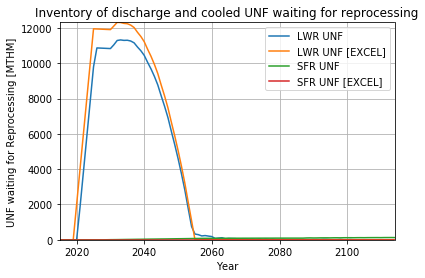

In [42]:
Image('./results/waiting.png')

In [43]:
# annual reprocessing throughput
uox_rep_agentid = an.get_prototype_id(cur, 'uox_reprocessing')
uox_rep = cur.execute('SELECT Time, Value from separationevents '
                      'WHERE Type = "UNF" AND Agentid = ' + uox_rep_agentid[0]).fetchall()
uox_rep = twosum(an.get_timeseries(uox_rep, duration, True))

sfr_rep_agentid = an.get_prototype_id(cur, 'sfr_reprocessing')
sfr_rep = cur.execute('SELECT Time, Value from separationevents '
                      'WHERE Type = "UNF" AND Agentid = ' + sfr_rep_agentid[0]).fetchall()
sfr_rep = twosum(an.get_timeseries(sfr_rep, duration, True))

# get from data
data_uox_rep = read_from_data('./bo/lwr_rep')
data_sfr_rep = read_from_data('./bo/sfr_rep')

plt.plot(new_timestep + init_year, uox_rep, label='LWR UNF')
plt.plot(new_timestep + init_year, data_uox_rep, label='LWR UNF [EXCEL]')

plt.plot(new_timestep + init_year, sfr_rep, label='SFR UNF')
plt.plot(new_timestep + init_year, data_sfr_rep, label='SFR UNF [EXCEL]')

plt.xlabel('Year')
plt.ylabel('Annual Reprocessing Rate [t/y]')
plt.title('Annual reprocessing throughputs')
plt.legend()
axes = plt.gca()
plt.grid(True)
plt.savefig('./results/rep.png', format='png',
            bbox_inches='tight')
plt.close()


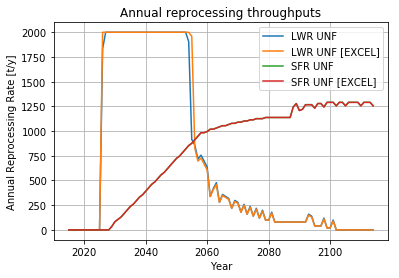

In [44]:
Image('./results/rep.png')